In [1]:
import pandas as pd
import numpy as np
from hyperopt import fmin, hp
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv("sets_de_datos/train.csv", index_col=0)

In [3]:
train["fecha"] = pd.to_datetime(train["fecha"])
train["fecha_n"] = train["fecha"].dt.year * 10000 + train["fecha"].dt.month * 100 + train["fecha"].dt.day

In [4]:
col_borrar = ["direccion", "lat", "lng", "titulo", "descripcion", "idzona", "fecha"]
train_1 = train.drop(col_borrar, axis=1)

In [5]:
train_1 = train_1.fillna(value = {'tipodepropiedad' : 'nan', 'provincia' : 'nan', 'ciudad' : 'nan'})

for c in ["antiguedad", "metrostotales", "metroscubiertos"]:
    imputer = SimpleImputer(strategy="mean")
    train_1[c] = imputer.fit_transform(train_1[[c]])

for c in ["habitaciones", "banos", "garages"]:
    imputer = SimpleImputer(strategy="constant", fill_value=0)
    train_1[c] = imputer.fit_transform(train_1[[c]])

In [6]:
col_categoricas = ["provincia", "ciudad", "tipodepropiedad"]
col_datos = train_1.dtypes[train.dtypes != "object"].index

In [7]:

codificador = LabelEncoder()
train_codificado = train_1[col_categoricas].apply(codificador.fit_transform)
    

In [8]:
train_2 = train_1[col_datos].join(train_codificado)

In [9]:
datos = train_2.drop(["precio"], axis=1)
precio = train_2["precio"]

## ========================Empiezo con hyperopt========================

In [51]:
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pylab as plt

In [19]:
from sklearn.model_selection import cross_val_score

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

#### Empiezo con un ejemplo facilito para familiarizarme

In [21]:
def hyperopt_train_test(params):
    modelo = XGBRegressor(**params)
    return cross_val_score(modelo, datos, precio).mean()

In [31]:
space_xgb = {
    "objective" : "reg:squarederror",
    "subsample" : hp.uniform("subsample", 0, 1),
    "n_estimators" : hp.choice("n_estimators", range(1000, 2001)),
    "min_child_weight" : hp.choice("min_child_weight", range(1,6)),
    "max_depth" : hp.choice("max_depth", range(3, 11)),
    "learning_rate" : hp.uniform("learning_rate", 0.01, 0.2),
    "reg_lambda" : hp.uniform("reg_lambda", 0.03, 0.3),
    "gamma" : hp.uniform("gamma", 0, 0.5),
    "colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1),
    "subsample" : hp.uniform("subsample", 0.5, 1)
}

In [23]:
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

In [24]:
trials = Trials()

In [25]:
best = fmin(f, space_xgb, algo=tpe.suggest, max_evals=2, trials=trials)

  0%|          | 0/2 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



 50%|█████     | 1/2 [29:36<29:36, 1776.68s/it, best loss: -0.7951106208271902]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



100%|██████████| 2/2 [47:45<00:00, 1432.73s/it, best loss: -0.7951106208271902]


In [30]:
best

{'colsample_bytree': 0.8025664429969347,
 'gamma': 0.39002946109393183,
 'learning_rate': 0.03363445761972082,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 782,
 'reg_lambda': 0.15044080831403747,
 'subsample': 0.7144628828762032}

In [39]:
modelo = XGBRegressor(
    objective = "reg:squarederror",
    colsample_bytree = 0.8025664429969347,
    gamma = 0.39002946109393183,
    learning_rate = 0.03363445761972082,
    max_depth = 6,
    min_child_weight = 3,
    n_estimators = 782,
    reg_lambda = 0.15044080831403747,
    subsample = 0.7144628828762032
)

In [40]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, precio_train, precio_test = train_test_split(datos, precio, test_size=0.25, random_state=42)
predictor = modelo.fit(datos_train, precio_train)

Text(0, 0.5, 'Feature Importance Score')

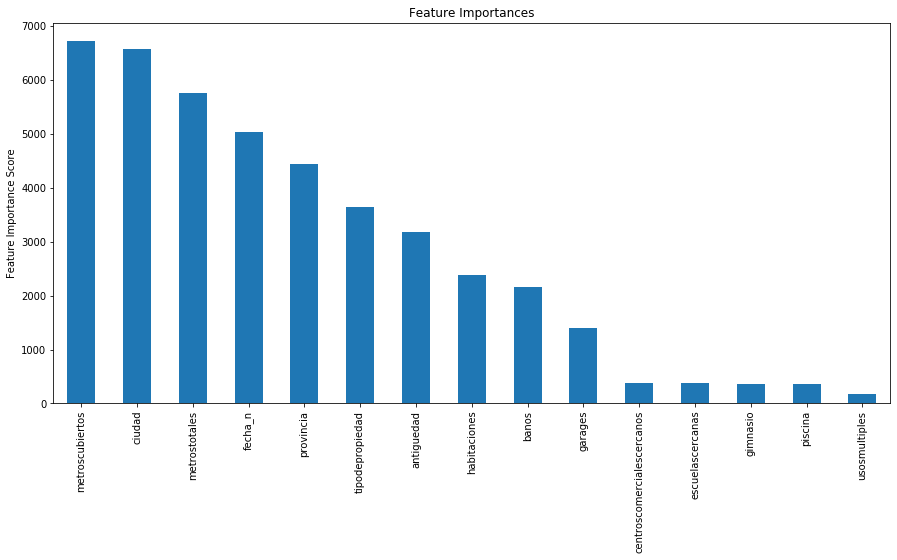

In [86]:
feat_imp = pd.Series(predictor.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(15, 7))
plt.ylabel('Feature Importance Score')

In [59]:
for t in trials:
    print(t)

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.7951106208271902, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'colsample_bytree': [0], 'gamma': [0], 'learning_rate': [0], 'max_depth': [0], 'min_child_weight': [0], 'n_estimators': [0], 'reg_lambda': [0], 'subsample': [0]}, 'vals': {'colsample_bytree': [0.8025664429969347], 'gamma': [0.39002946109393183], 'learning_rate': [0.03363445761972082], 'max_depth': [6], 'min_child_weight': [3], 'n_estimators': [782], 'reg_lambda': [0.15044080831403747], 'subsample': [0.7144628828762032]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 11, 24, 16, 21, 13, 921000), 'refresh_time': datetime.datetime(2019, 11, 24, 16, 50, 50, 556000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': -0.7841159536522788, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'colsample_bytree

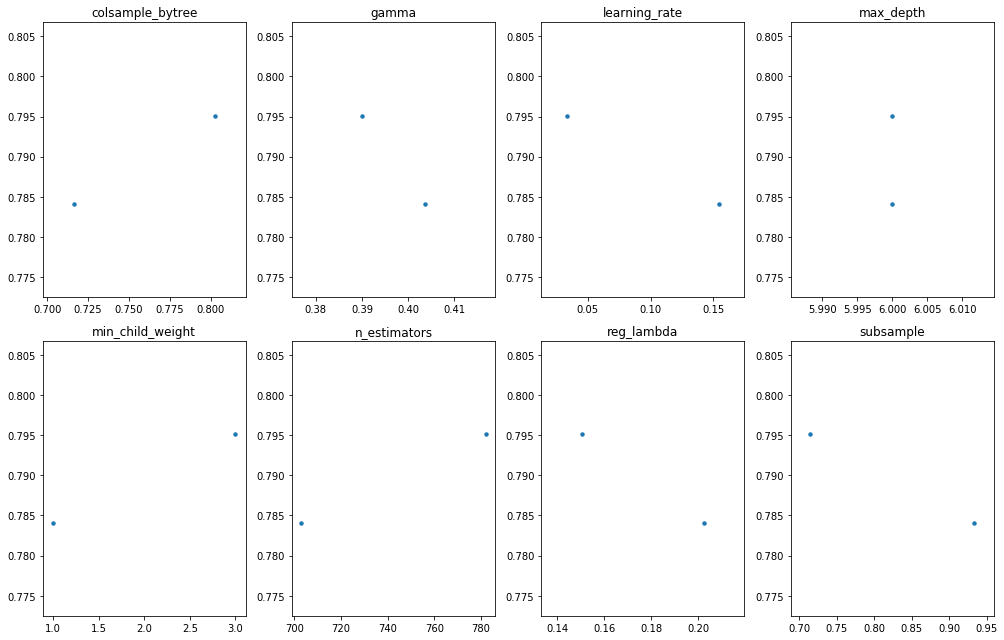

In [83]:
hyperp = ["colsample_bytree", "gamma", "learning_rate", "max_depth", "min_child_weight", "n_estimators", "reg_lambda", "subsample"]
fig, a = plt.subplots(2, 4, figsize=(14, 9))
for (i, e) in enumerate(hyperp):
    x = [t["misc"]["vals"][e] for t in trials]
    y = [-t["result"]["loss"] for t in trials]
    a[int(i/4), i%4].scatter(x, y, s=20, linewidth=0.01)
    a[int(i/4), i%4].set_title(e)
    
plt.tight_layout()

### ================================================================================

In [122]:
#Hago funciones que encodeen de distintas maneras
def label_encoding(df, col_categ, col_datos):
    codificador = LabelEncoder()
    cod = df[col_categ].apply(codificador.fit_transform)
    return df[col_datos].join(cod)
    
from category_encoders.target_encoder import TargetEncoder
    
def target_encoding(datos, precio, cols):
    codificador = TargetEncoder(cols=cols)
    return codificador.fit_transform(datos, precio)
    

In [123]:
datos_1 = train_1.drop(["precio"], axis=1)
precio_1 = train_1["precio"]

In [124]:
LABEL = 0
TARGET = 1
COL_CATEGORICAS = ["provincia", "ciudad", "tipodepropiedad"]
COL_DATOS = datos_1.dtypes[datos_1.dtypes != "object"].index

In [125]:
def hyperopt_train_test_1(params, datos, precio):
    if params["encoder"] == LABEL:
        datos_ = label_encoding(datos, COL_CATEGORICAS, COL_DATOS)
    if params["encoder"] == TARGET:
        datos_ = target_encoding(datos, precio, COL_CATEGORICAS)
    
    modelo = XGBRegressor(**params)
    return cross_val_score(modelo, datos_, precio).mean()

In [126]:
space_xgb_1 = {
    "encoder" : hp.choice("encoder", [LABEL, TARGET]),
    "objective" : "reg:squarederror",
    "subsample" : hp.uniform("subsample", 0, 1),
    "n_estimators" : hp.choice("n_estimators", range(1000, 2001)),
    "min_child_weight" : hp.choice("min_child_weight", range(1,6)),
    "max_depth" : hp.choice("max_depth", range(3, 11)),
    "learning_rate" : hp.uniform("learning_rate", 0.01, 0.2),
    "reg_lambda" : hp.uniform("reg_lambda", 0.03, 0.3),
    "gamma" : hp.uniform("gamma", 0, 0.5),
    "colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1),
    "subsample" : hp.uniform("subsample", 0.5, 1)
}

In [127]:
def f_1(params):
    acc = hyperopt_train_test_1(params, datos_1, precio_1)
    return {'loss': -acc, 'status': STATUS_OK}

In [128]:
trials_1 = Trials()

In [133]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [134]:
best_1 = fmin(f_1, space_xgb_1, algo=tpe.suggest, max_evals=15, trials=trials_1)

100%|██████████| 11/11 [2:36:21<00:00, 852.82s/it, best loss: -0.7976728298082255]


In [135]:
best_1

{'colsample_bytree': 0.8979661085404547,
 'encoder': 1,
 'gamma': 0.41696802132772404,
 'learning_rate': 0.025121413742224204,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 569,
 'reg_lambda': 0.09123601891042732,
 'subsample': 0.8726447041191638}

In [142]:
best_1["objective"] = "reg:squarederror"

In [143]:
best_1

{'colsample_bytree': 0.8979661085404547,
 'encoder': 1,
 'gamma': 0.41696802132772404,
 'learning_rate': 0.025121413742224204,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 569,
 'reg_lambda': 0.09123601891042732,
 'subsample': 0.8726447041191638,
 'objective': 'reg:squarederror'}

In [144]:
modelo_1 = XGBRegressor(**best_1)

In [145]:
datos_te = target_encoding(datos_1, precio_1, COL_CATEGORICAS)

In [146]:
datos_train_1, datos_test_1, precio_train_1, precio_test_1 = train_test_split(datos_te, precio_1, test_size=0.25, random_state=42)
predictor_1 = modelo_1.fit(datos_train_1, precio_train_1)

Text(0, 0.5, 'Feature Importance Score')

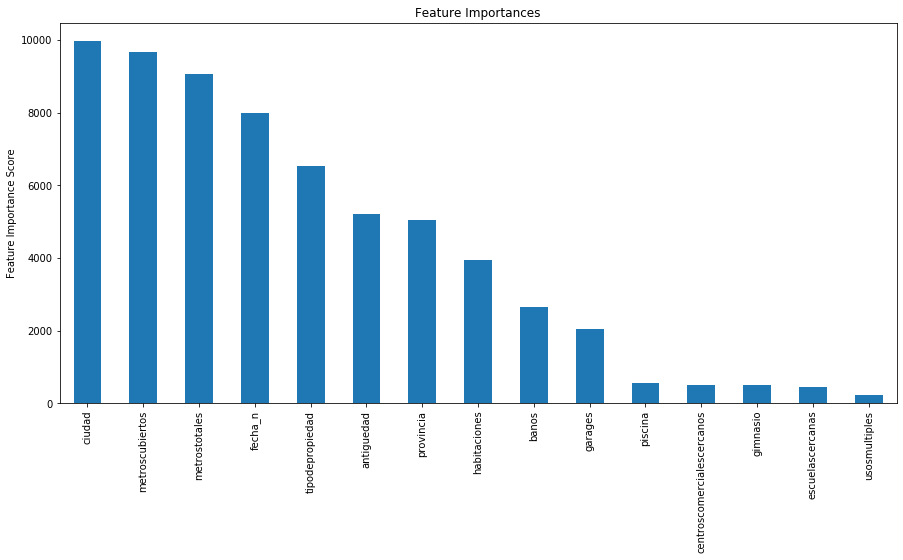

In [147]:
feat_imp_1 = pd.Series(predictor_1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp_1.plot(kind='bar', title='Feature Importances', figsize=(15, 7))
plt.ylabel('Feature Importance Score')

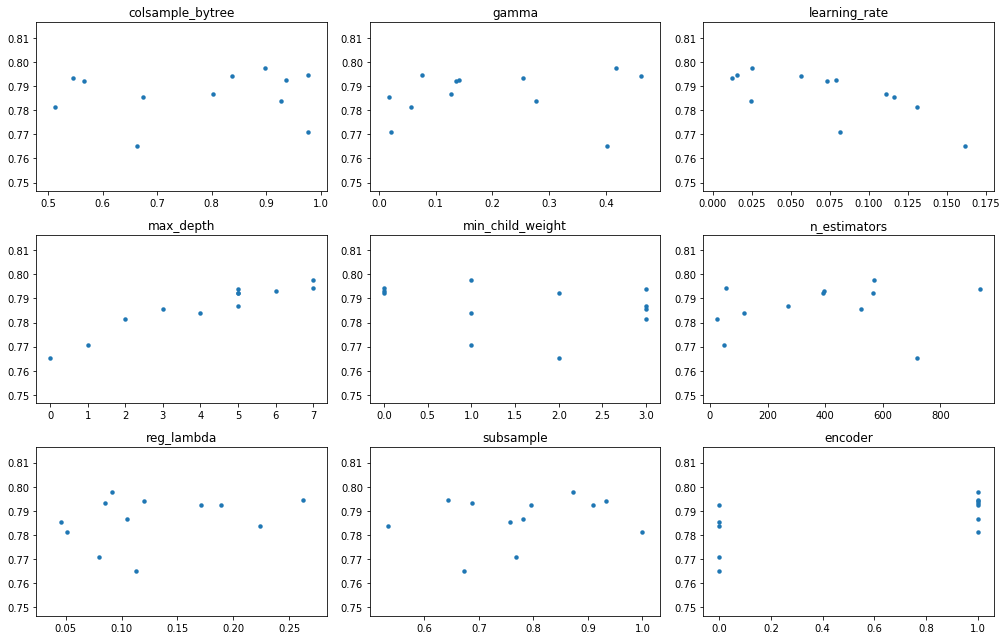

In [153]:
hyperp_1 = ["colsample_bytree", "gamma", "learning_rate", "max_depth", "min_child_weight", "n_estimators", "reg_lambda", "subsample", "encoder"]
fig_1, a_1 = plt.subplots(3, 3, figsize=(14, 9))
for (i, e) in enumerate(hyperp_1):
    x = [t["misc"]["vals"][e] for t in trials_1 if ("loss" in t["result"])]
    y = [-t["result"]["loss"] for t in trials_1 if ("loss" in t["result"])]
    a_1[int(i/3), i%3].scatter(x, y, s=20, linewidth=0.01)
    a_1[int(i/3), i%3].set_title(e)
    
plt.tight_layout()

In [154]:
#TODO: Poner lindo el notebook